# Modeling Isomerization of 1,5-cyclooctadiene

Prepared by: Feng Gao - fgao2@nd.edu and Sam Zhang - szhang32@nd.edu

__References:__

Based on Problem3 HW3 of Chemical Reaction Engineering Class of Prof.Hicks (2023), with permission.

Nishiguchi, T., H. Imai, and K. Fukuzumi. 1975. Catal. 39 (3): 375- 382.

Yanlong, Q., and X. Weihua. 1986. J. Mol. Catal. 34 (1): 31-38.(https://colab.research.google.com/drive/1K0twABdh7iWOVkRLfqNJHRxa1fsiHLDf?usp=sharing)


## Problem Description
This problem is meant to provide practice for undergraduate students in using simulation to model and understand chemical engineering reaction kinetics, and specifically to have a better understanding of the kinetics of isomerization.

Aditionaly, doing this project is a chance to learn and practice solving ODEs and using nonlinear regression to predict reaction parameters.

After working on this project, the students also be more familier using Numpy library which help in constructing array, matrix, and multiple mathematics functions, Scipy library which help in solving integral function more efficiently in this project as well as nonlinear regression, and Matplotlib which provides visualization when they graph.

##Useful links to review library
1. Numpy

    https://ndcbe.github.io/data-and-computing/notebooks/01/NumPy.html?highlight=numpy#getting-started-with-numpy-arrays

2. Scipy

    https://docs.scipy.org/doc/numpy-1.15.0/user/quickstart.html

    https://ndcbe.github.io/data-and-computing/notebooks/04/Linear-Algebra-in-Numpy.html?highlight=scipy#scipy
    
3. Matplotlib

    https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html#matplotlib-basics

    https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html#customizing-plots
    
    https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html#plotting-multiple-lines

##Import libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import t
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# 1. Background: Modeling isomerization of 1,5-cyclooctadiene

In chemistry, isomerization or isomerisation is the process in which a molecule, polyatomic ion or molecular fragment is transformed into an isomer with a different chemical structure. Enolization is an example of isomerization, as is tautomerization. When the isomerization occurs intramolecularly it may be called a rearrangement reaction.

1,5-cyclooctadiene is a cyclic hydrocarbon with two double bonds located at the 1st and 5th positions in its eight-carbon ring structure. Isomerization in the liquid phase typically involves the conversion of this compound into its isomeric forms, such as 1,3-cyclooctadiene, through the rearrangement of the double bonds.

The process is often catalyzed by transition metal complexes, such as those containing palladium or platinum. These catalysts play a crucial role in facilitating the movement of double bonds and promoting the formation of new isomers. The choice of catalyst, reaction conditions (temperature, pressure, and solvent), and the presence of co-catalysts can significantly influence the efficiency and selectivity of the isomerization reaction.


## 1.1. Learning Goals
**General goal:**

•	Mathematical Modeling: Using ordinary differential equation (ODE) to model and analyze species' concentration variation against time.

•	Simulation: By writing up Python code, the translation of theoretical models into practical simulations is strengthened.

•	Visualization: Creating plots to visualize the reaction process interpret data to validate mechanism.


**Specific goal:**

•	Analyze the reaction kinetics for series reaction, understand how to apply rate constant and species balance.

•	Model the reaction kinetics of liquid phase isomerization of 1,5-cyclooctadiene transition metal catalyst.

•	Find intermediate maximum concentration by solving the ODE with integrate from scipy ($t_{opt}$ for intermediate).

•	Verify the right mechanism by applying experimental data.


## 1.2. Problem Statement
The liquid phase isomerization of 1,5-cyclooctadiene with transition metal- based catalyst. Researchers have attempted to model the reactions in two ways:

Case 1. As a set of consecutive pseudo first-order reactions of the form:

$$
A \xrightarrow{k_1} B \xrightarrow{k_2} C
$$

Case 2. As a set of competitive pseudo first-order reactions of the form:

$$
A \xrightarrow{k_3} B \xrightarrow{k_4} C
$$
$$
A\xrightarrow{k_5} C
$$



Where **A** refers to 1,5-cyclooctadiene, **B** to 1,4-cyclooctadiene, and **C** to 1,3-cyclooctadiene.





#2. Analysis

## 2.1. Visualizing the dimensionless concentration of each specie verses time (Case1)

The first mechanism involves 2 steps and 3 species.

__1. Rate of species A__
\begin{equation}
r_A = \frac{d[A]}{dt} = -k_1 \cdot [A]
\end{equation}

__2. Rate of species B__
\begin{equation}
r_B = \frac{d[B]}{dt} = k_1 \cdot [A] - k_2 \cdot [B]
\end{equation}

__3. Rate of species C__
\begin{equation}
r_C = \frac{d[C]}{dt} = k_2 \cdot [B]
\end{equation}

Note that to have the $[B]_{max}$, the external condition is given: at t=0, dB/dT ≥ 0, thus for
\begin{equation}
\frac{d[B]}{dt} = k_1 \cdot [A_0] - k_2 \cdot [B_0] ≥ 0
\end{equation}
Therefore
\begin{equation}
\frac{k_1 \cdot [A_0]}{k_2\cdot[B_0]} ≥ 1
\end{equation}

###2.1.1. Setup Function: Define rate constants and initial conditions.

In [44]:
def setup_case1(A0, B0, k1, k2):
    """
    Sets up the initial conditions and rate constants for the isomerization reaction.

    Args:
        A0: Initial concentration of species A
        B0: Initial concentration of species B
        k1: Rate constant for the reaction A -> B
        k2: Rate constant for the reaction B -> C

    Returns:
        initial_conditions: Initial concentrations for A, B, and C
        rate_constants: Rate constants for the reaction
    """
    C0 = 0.0  # Initial concentration of species C is always 0
    initial_conditions = [A0, B0, C0]
    rate_constants = {'k1': k1, 'k2': k2}
    return initial_conditions, rate_constants

###2.1.2. ODE Function: Define the system of ODEs for the concentrations of A, B, and C.

In [45]:
def case1_kinetics(t, y, rate_constants):
    """
    RHS of differential equation for reaction kinetics.

    Args:
        t: Time
        y: Values for differential equations, [A, B, C]
        rate_constants: Dictionary containing rate constants for the reaction

    Returns:
        dydt: First derivative of y w.r.t. t
    """
    A, B, C = y
    k1 = rate_constants['k1']
    k2 = rate_constants['k2']

    # Define the ODEs
    dA_dt = -k1 * A
    dB_dt = k1 * A - k2 * B
    dC_dt = k2 * B

    # Return the derivatives
    dydt = [dA_dt, dB_dt, dC_dt]
    return dydt

###2.1.3. Solver Function: Use scipy to solve the ODEs and get the concentration of species A, B and C at time t.

In [46]:
def solve_case1_ode(initial_conditions, rate_constants, tmax):
    """
    Solves differential equations for the isomerization reaction.

    Args:
        initial_conditions: Initial concentrations for A, B, and C
        rate_constants: Rate constants for the reaction
        tmax: The amount of time to simulate

    Returns:
        A: Concentration profile of species A
        B: Concentration profile of species B
        C: Concentration profile of species C
        t: Time array for the simulation
    """
    t = np.linspace(0, tmax, num=int(tmax*100)+1)
    tspan = [t[0], t[-1]]

    # Solve the ODEs
    soln = integrate.solve_ivp(case1_kinetics, tspan, initial_conditions, args=(rate_constants,), t_eval=t, method='RK45')

    A = soln.y[0]
    B = soln.y[1]
    C = soln.y[2]

    return A, B, C, t

###2.1.4. An example with specified variable values and find $t_{opt}$:
Given that $A_0$ = $1.0$ $M$, $B_0$ = $0.0$ $M$, $k_1$ = $1.0$ * $10^{-3}$ $s^{-1}$, $k_2$ = $0.5$ * $10^{-3}$ $s^{-1}$, $t_{max}$ = $10000$ $s$

We hope to determine the time at which the concentration of species B reaches its maximum. This specific point in time is defined as $t_{opt}$.

To find $t_{opt}$, we need to find the time at which the derivative of B with respect to time is zero.

That is to solve:

\begin{equation}
\frac{d[B]}{dt} = 0
\end{equation}


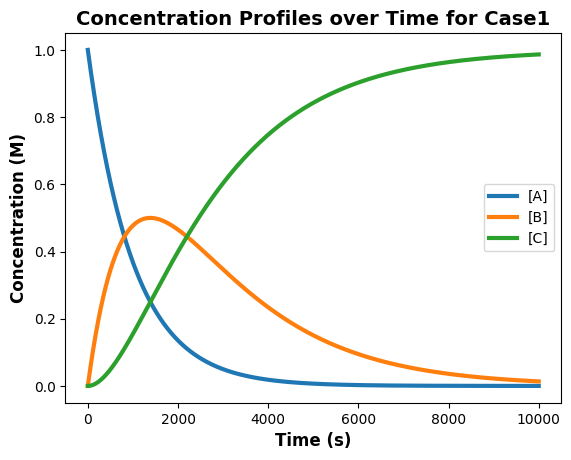

The time corresponding to the maximum concentration of B (t_opt) is: 1386.19 seconds


In [47]:
# Example
A0 = 1.0  # Initial concentration of A
B0 = 0.0  # Initial concentration of B
k1 = 0.001  # Rate constant for A -> B
k2 = 0.0005  # Rate constant for B -> C
tmax = 10000  # Total time for the simulation

initial_conditions, rate_constants = setup_case1(A0, B0, k1, k2)
A, B, C, t = solve_case1_ode(initial_conditions, rate_constants, tmax)

# Plot the results
plt.plot(t, A, label='[A]',linewidth=3)
plt.plot(t, B, label='[B]',linewidth=3)
plt.plot(t, C, label='[C]',linewidth=3)
plt.legend()
plt.xlabel('Time (s)',fontweight='bold',fontsize=12)
plt.ylabel('Concentration (M)',fontweight='bold',fontsize=12)
plt.title('Concentration Profiles over Time for Case1', fontweight='bold',fontsize=14)
plt.show()

### Find the t_opt for species B
# Convert B to a numpy array for differentiation
B_np = np.array(B)
# Calculate the gradient of B with respect to time
gradient_B = np.gradient(B_np, t)

# Find where the gradient changes sign
max_idx = np.where(np.diff(np.sign(gradient_B)))[0]

# If max_idx is not empty, we have found a local maximum
if max_idx.size > 0:
    t_opt = t[max_idx[0]]
    B_max = B[max_idx[0]]
    print(f"The time corresponding to the maximum concentration of B (t_opt) is: {t_opt} seconds")
else:
    print("No local maximum found for the concentration of B within the given time frame.")

##2.2. Visualizing the dimensionless concentration of species B verses time (Case2)

The second mechanism involves 3 steps and 3 species.

__1. Rate of species A__
\begin{equation}
r_A = \frac{d[A]}{dt} = -k_3 \cdot [A] - k_5 \cdot [A]
\end{equation}

__2. Rate of species B__
\begin{equation}
r_B = \frac{d[B]}{dt} = k_3 \cdot [A] - k_4 \cdot [B]
\end{equation}

__3. Rate of species C__
\begin{equation}
r_C = \frac{d[C]}{dt} = k_4 \cdot [B] + k_5 \cdot [B]
\end{equation}

Note that to have the $[B]_{max}$, the external condition is given: at t=0, dB/dT ≥ 0, thus for


\begin{equation}
\frac{d[B]}{dt} = k_3 \cdot [A_0] - k_4 \cdot [B_0] ≥ 0
\end{equation}
Therefore


\begin{equation}
\frac{k_3 \cdot [A_0]}{k_4\cdot[B_0]} ≥ 1
\end{equation}

### 2.2.1. Setup Function: Define rate constants and initial conditions.

In [48]:
def setup_case2(A0, B0, C0, k3, k4, k5):
    """
    Sets up the initial conditions and rate constants for Case 2 of the reaction.

    Args:
        A0: Initial concentration of species A
        B0: Initial concentration of species B
        C0: Initial concentration of species C
        k3: Rate constant for the reaction A -> B
        k4: Rate constant for the reaction B -> C
        k5: Rate constant for the reaction A -> C (competing reaction)

    Returns:
        initial_conditions: Initial concentrations for A, B, and C
        rate_constants: Rate constants for the reaction
    """
    initial_conditions = [A0, B0, C0]
    rate_constants = {'k3': k3, 'k4': k4, 'k5': k5}
    return initial_conditions, rate_constants

###2.2.2. ODE Function: Define the system of ODEs for the concentrations of A, B, and C.

In [49]:
def case2_kinetics(t, y, rate_constants):
    """
    RHS of differential equation for Case 2 reaction kinetics.

    Args:
        t: Time
        y: Values for differential equations, [A, B, C]
        rate_constants: Dictionary containing rate constants for the reaction

    Returns:
        dydt: First derivative of y w.r.t. t
    """
    A, B, C = y
    k3 = rate_constants['k3']
    k4 = rate_constants['k4']
    k5 = rate_constants['k5']

    # Define the ODEs
    dA_dt = -k3 * A - k5 * A
    dB_dt = k3 * A - k4 * B
    dC_dt = k4 * B + k5 * A

    # Return the derivatives
    dydt = [dA_dt, dB_dt, dC_dt]
    return dydt

###2.2.3. Solver Function: Use scipy to solve the ODEs.

In [50]:
def solve_case2_ode(initial_conditions, rate_constants, tmax):
    """
    Solves differential equations for Case 2 of the isomerization reaction.

    Args:
        initial_conditions: Initial concentrations for A, B, and C
        rate_constants: Rate constants for the reaction
        tmax: The amount of time to simulate

    Returns:
        A: Concentration profile of species A
        B: Concentration profile of species B
        C: Concentration profile of species C
        t: Time array for the simulation
    """
    t = np.linspace(0, tmax, num=int(tmax*100)+1)
    tspan = [t[0], t[-1]]

    # Solve the ODEs
    soln = integrate.solve_ivp(case2_kinetics, tspan, initial_conditions, args=(rate_constants,), t_eval=t, method='RK45')

    A = soln.y[0]
    B = soln.y[1]
    C = soln.y[2]

    return A, B, C, t

###2.2.4. An example with specified variable values and find $t_{opt}$:
Given that: $A_0$ = $1.0$ $M$, $B_0$ = $0.0$ $M$, $C_0$ = $0.0$ $M$, $k_3$ = $1.0$ * $10^{-3}$ $s^{-1}$, $k_4$ = $0.5$ * $10^{-3}$ $s^{-1}$, $k_5$ = $1.0$ * $10^{-3}$ $s^{-1}$, $t_{max}$ = $10000$ $s$

To find $t_{opt}$, we need to find the time at which the derivative of B with respect to time is zero.

That is to solve:

\begin{equation}
\frac{d[B]}{dt} = 0
\end{equation}


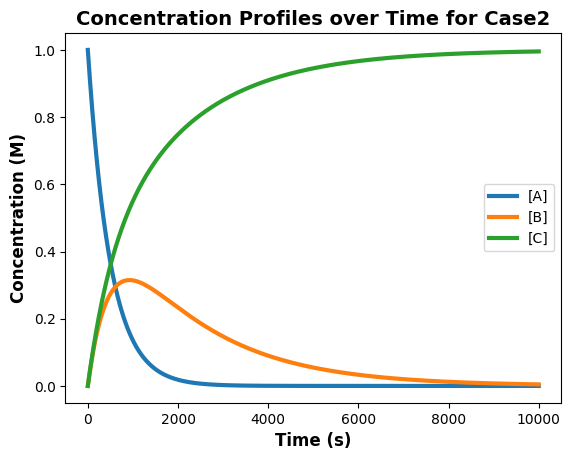

The time corresponding to the maximum concentration of B (t_opt) is: 925.6 seconds


In [51]:
# Example
A0 = 1.0  # Initial concentration of A
B0 = 0.0  # Initial concentration of B
C0 = 0.0  # Initial concentration of C
k3 = 0.001  # Rate constant for A -> B
k4 = 0.0005  # Rate constant for B -> C
k5 = 0.001  # Rate constant for A -> C (competing reaction)
tmax = 10000  # Total time for the simulation

initial_conditions, rate_constants = setup_case2(A0, B0, C0, k3, k4, k5)
A, B, C, t = solve_case2_ode(initial_conditions, rate_constants, tmax)

# Plot the results
plt.plot(t, A, label='[A]',linewidth=3)
plt.plot(t, B, label='[B]',linewidth=3)
plt.plot(t, C, label='[C]',linewidth=3)
plt.legend()
plt.xlabel('Time (s)',fontweight='bold', fontsize=12)
plt.ylabel('Concentration (M)',fontweight='bold', fontsize=12)
plt.title('Concentration Profiles over Time for Case2',fontweight='bold',fontsize=14)
plt.show()

### Find the t_opt for species B
# Convert B to a numpy array for differentiation
B_np = np.array(B)
# Calculate the gradient of B with respect to time
gradient_B = np.gradient(B_np, t)

# Find where the gradient changes sign
max_idx = np.where(np.diff(np.sign(gradient_B)))[0]

# If max_idx is not empty, we have found a local maximum
if max_idx.size > 0:
    t_opt = t[max_idx[0]]
    B_max = B[max_idx[0]]
    print(f"The time corresponding to the maximum concentration of B (t_opt) is: {t_opt} seconds")
else:
    print("No local maximum found for the concentration of B within the given time frame.")

## 2.3. Validate the mechanism with experimental data

### 2.3.1. Let's look at the plot using the given rate constants $k$ and experiment data first

Consider the situation in which only reactant A is present initially. Prepare plots of the dimensionless concentration of species B (i.e., $B$/$A_0$) verses time (180 minutes) for each of the two cases noted above using the following values of the rate constants (in $s^{-1}$) at 160 °C.

$k_1$ = $0.45$ * $10^{-3}$ $s^{-1}$, $k_2$ = $5.0$ * $10^{-3}$ $s^{-1}$, $k_3$ = $0.32$ * $10^{-4}$ $s^{-1}$, $k_4$ = $1.6$ * $10^{-4}$ $s^{-1}$, $k_5$ = $4.2$ * $10^{-4}$ $s^{-1}$, $t_{max}$ = $180$ $min$


|Additional Information           ||  |
|-----------------------------------||---------------------------------|
|**Time(min)**             || **B(%w/w)**            |
|0            ||  0 |
|20             || 2.3       |
|30   || 3.5          |
|60                   || 4.2    |
|90           || 3.2 |
|120                     || 2.4  |
|180              || 2.0 |


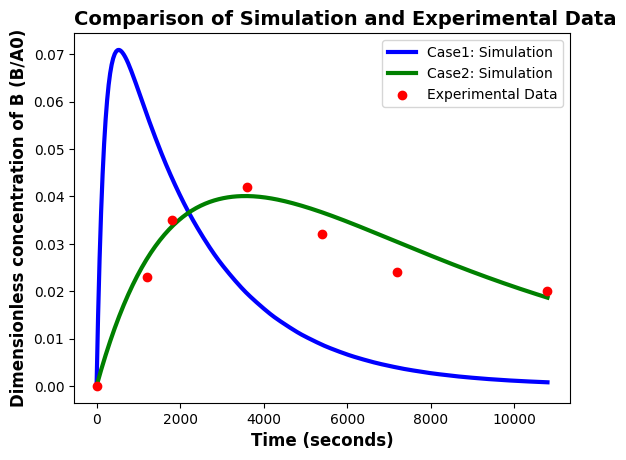

In [52]:
# Given rate constants in s^-1
k1 = 0.45e-3
k2 = 5.0e-3
k3 = 0.32e-4
k4 = 1.6e-4
k5 = 4.2e-4

# Initial conditions: only A is present initially
A0 = 1.0  # Assume 100% A initially for dimensionless concentration
B0 = 0.0
C0 = 0.0

# Time span (convert 180 minutes to seconds)
tmax = 180 * 60  # seconds
time_points = np.linspace(0, tmax, 300)  # Create 300 time points for smooth curves

# Rate constants in dictionary form
rate_constants_case1 = {'k1': k1, 'k2': k2}
rate_constants_case2 = {'k3': k3, 'k4': k4, 'k5': k5}

# Solve ODEs for both cases
solution_case1 = solve_ivp(lambda t, y: case1_kinetics(t, y, rate_constants_case1), [0, tmax], [A0, B0, C0], t_eval=time_points)
solution_case2 = solve_ivp(lambda t, y: case2_kinetics(t, y, rate_constants_case2), [0, tmax], [A0, B0, C0], t_eval=time_points)

# Experimental data converted to seconds and dimensionless concentration
experimental_time = np.array([0, 20, 30, 60, 90, 120, 180]) * 60
experimental_B = np.array([0, 2.3, 3.5, 4.2, 3.2, 2.4, 2.0]) / 100

# Plotting both cases and experimental data
#plt.figure(figsize=(12, 6))

# Case 1
plt.plot(solution_case1.t, solution_case1.y[1] / A0, label='Case1: Simulation', color='blue',linewidth=3)

# Case 2
plt.plot(solution_case2.t, solution_case2.y[1] / A0, label='Case2: Simulation', color='green',linewidth=3)

# Experimental data
plt.scatter(experimental_time, experimental_B, color='red', label='Experimental Data', zorder=5)

plt.xlabel('Time (seconds)',fontweight='bold',fontsize=12)
plt.ylabel('Dimensionless concentration of B (B/A0)',fontweight='bold',fontsize=12)
plt.title('Comparison of Simulation and Experimental Data',loc='left', fontweight='bold',fontsize=14)
plt.legend()
plt.show()

### 2.3.2. Using nonlinear regression to predict the vaules of rate constants for Case1 and Case2

We esimate the unknown model parameters, i.e., rate constants from data by solving a nonlinear regression problem.

### Main Idea

The core of our approach lies in solving an optimization problem: minimizing the sum of squared differences between the observed data ${y_i} $ and the predictions from our mode ($\hat{y}_i$),expressed as:

$$\min_{\hat{\theta}} \quad \sum (y_i - \hat{y}_i)^2$$

computationally. This works even if $\hat{y_i} = f(\hat{\theta}, x_i)$ is a nonlinear function, where ${\theta}$ encapsulates the model parameters - in our context, these are the rate constants of the chemical reactions. The independent variables ${x_i}$ , could include factors like reactant concentrations.



In [53]:
# Experimental data (time in seconds, B/A0 as dimensionless concentration)
experimental_time = np.array([0, 20, 30, 60, 90, 120, 180]) * 60  # Convert minutes to seconds
experimental_B_A0 = np.array([0, 2.3, 3.5, 4.2, 3.2, 2.4, 2.0]) / 100  # Convert %w/w to fraction

# Time span for solving ODEs
tmax = 180 * 60  # 180 minutes in seconds
time_points = np.linspace(0, tmax, 300)  # Create time points for ODE solver

# ODE function for Case 1
def case1_kinetics(t, y, k1, k2):
    A, B, C = y
    dA_dt = -k1 * A
    dB_dt = k1 * A - k2 * B
    dC_dt = k2 * B
    return [dA_dt, dB_dt, dC_dt]

# ODE function for Case 2
def case2_kinetics(t, y, k3, k4, k5):
    A, B, C = y
    dA_dt = -k3 * A - k5 * A
    dB_dt = k3 * A - k4 * B
    dC_dt = k4 * B + k5 * A
    return [dA_dt, dB_dt, dC_dt]

# Objective function for least squares fitting
def objective_function_case1(params):
    k1, k2 = params
    sol = solve_ivp(case1_kinetics, [0, tmax], [1.0, 0.0, 0.0], args=(k1, k2), t_eval=experimental_time)
    B_A0_predicted = sol.y[1] / 1.0
    return B_A0_predicted - experimental_B_A0

def objective_function_case2(params):
    k3, k4, k5 = params
    sol = solve_ivp(case2_kinetics, [0, tmax], [1.0, 0.0, 0.0], args=(k3, k4, k5), t_eval=experimental_time)
    B_A0_predicted = sol.y[1] / 1.0
    return B_A0_predicted - experimental_B_A0

# Initial guesses for the rate constants
initial_guess_case1 = [1e-4, 1e-3]  # Guesses for k1 and k2
initial_guess_case2 = [1e-5, 1e-4, 1e-4]  # Guesses for k3, k4, k5

# Perform least squares fitting
result_case1 = least_squares(objective_function_case1, initial_guess_case1)
result_case2 = least_squares(objective_function_case2, initial_guess_case2)

# Optimized rate constants
optimized_k1, optimized_k2 = result_case1.x
optimized_k3, optimized_k4, optimized_k5 = result_case2.x

optimized_k1, optimized_k2, optimized_k3, optimized_k4, optimized_k5

# Print the optimized rate constants for Case 1 (Consecutive Reactions)
print(f"Optimized rate constants for Case 1:")
print(f"k1 = {optimized_k1:.2e} s^-1")  # Scientific notation with 2 decimal places
print(f"k2 = {optimized_k2:.2e} s^-1")

# Print the optimized rate constants for Case 2 (Competitive Reactions)
print(f"\nOptimized rate constants for Case 2:")
print(f"k3 = {optimized_k3:.2e} s^-1")
print(f"k4 = {optimized_k4:.2e} s^-1")
print(f"k5 = {optimized_k5:.2e} s^-1")

Optimized rate constants for Case 1:
k1 = 4.90e-05 s^-1
k2 = 1.25e-03 s^-1

Optimized rate constants for Case 2:
k3 = 3.36e-05 s^-1
k4 = 1.44e-04 s^-1
k5 = 5.17e-04 s^-1


**Discussion:** Why do we need to redefine the reaction kinetics of ODEs here rather than using the previous ones?

**Answer:** When performing nonlinear regression using `scipy.optimize.least_squares` or similar methods, we need to pass the parameters (in this case, the rate constants $k_1, k_2, k_3, k_4, $ and $k_5$) as arguments to the objective function. This function then uses these parameters to solve the ODEs and compare the results with experimental data.

In the original definitions of the ODEs, the rate constants were defined as global variables or were set within the function but not as arguments. This works fine for initial simulations where the rate constants are known and fixed.


###2.3.3. We can plot nonlinear fit models of Case1 and Case2 as well as the experiment data

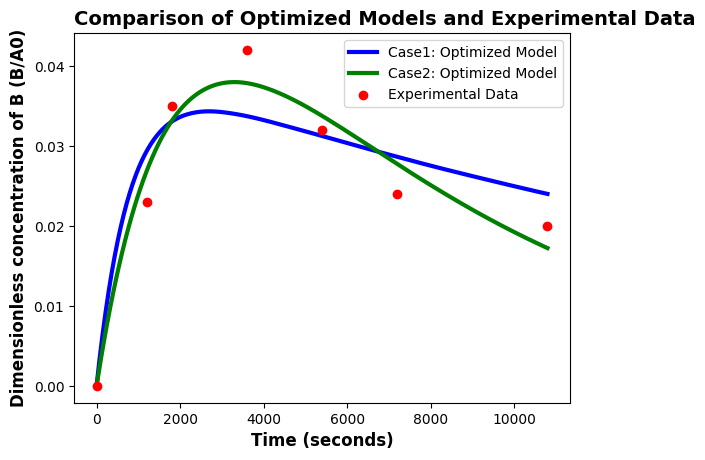

In [54]:
# Solve ODEs with optimized parameters for Case 1 and Case 2
solution_optimized_case1 = solve_ivp(case1_kinetics, [0, tmax], [A0, B0, C0], args=(optimized_k1, optimized_k2), t_eval=time_points)
solution_optimized_case2 = solve_ivp(case2_kinetics, [0, tmax], [A0, B0, C0], args=(optimized_k3, optimized_k4, optimized_k5), t_eval=time_points)

# Extracting B/A0 for both cases
B_A0_optimized_case1 = solution_optimized_case1.y[1] / A0
B_A0_optimized_case2 = solution_optimized_case2.y[1] / A0

# Plotting the results
#plt.figure(figsize=(12, 6))

# Case 1 with optimized parameters
plt.plot(solution_optimized_case1.t, B_A0_optimized_case1, label='Case1: Optimized Model', color='blue',linewidth=3)

# Case 2 with optimized parameters
plt.plot(solution_optimized_case2.t, B_A0_optimized_case2, label='Case2: Optimized Model', color='green',linewidth=3)

# Experimental data
plt.scatter(experimental_time, experimental_B_A0, color='red', label='Experimental Data', zorder=5)

plt.xlabel('Time (seconds)',fontsize=12,fontweight = 'bold')
plt.ylabel('Dimensionless concentration of B (B/A0)',fontsize=12,fontweight = 'bold')
plt.title('Comparison of Optimized Models and Experimental Data',loc='left', fontweight='bold',fontsize=14)
plt.legend()
plt.show()

### 2.3.4. Residual analysis

Mathematically, if ${y_i}$ is the observed value and ($\hat{y}_i$) is the predicted value for the $i$ observation, the residual ${e_i}$ is given by:
$$
\underbrace{e_i}_{\mathrm{residual}} = \underbrace{y_i}_\mathrm{observation} - \underbrace{\hat{y}_i}_{\mathrm{prediction}}
$$

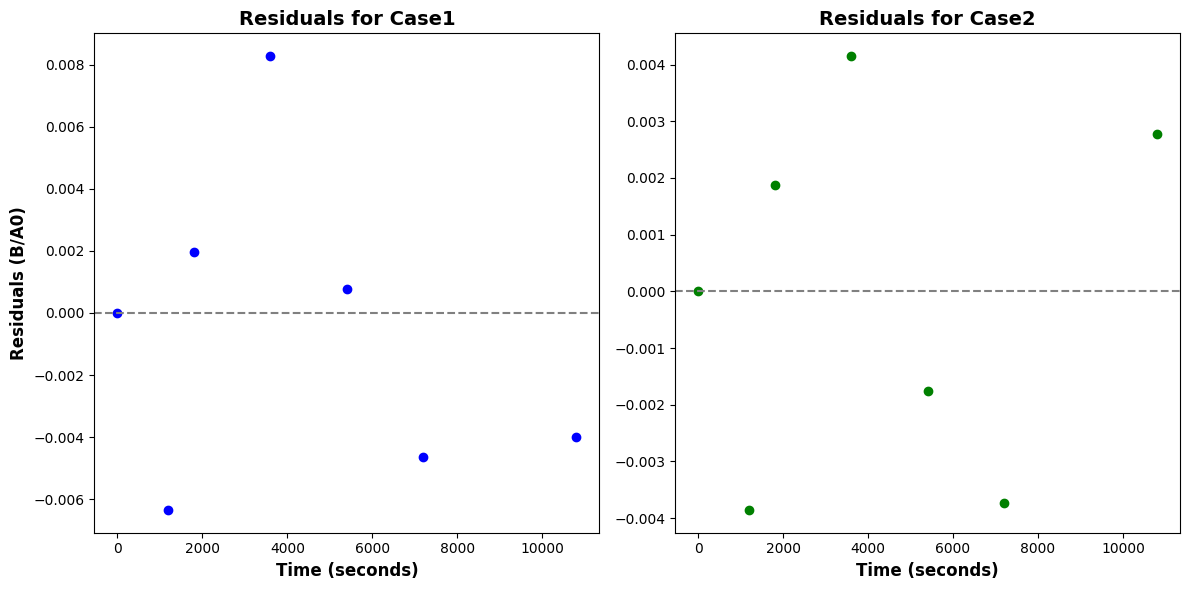

In [55]:
# Calculate residuals for Case 1 and Case 2
residuals_case1 = experimental_B_A0 - np.interp(experimental_time, solution_optimized_case1.t, B_A0_optimized_case1)
residuals_case2 = experimental_B_A0 - np.interp(experimental_time, solution_optimized_case2.t, B_A0_optimized_case2)

# Plotting residuals
plt.figure(figsize=(12, 6))

# Residuals for Case 1
plt.subplot(1, 2, 1)
plt.scatter(experimental_time, residuals_case1, color='blue')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Time (seconds)',fontsize=12,fontweight = 'bold')
plt.ylabel('Residuals (B/A0)',fontsize=12,fontweight = 'bold')
plt.title('Residuals for Case1',fontsize=14,fontweight = 'bold')

# Residuals for Case 2
plt.subplot(1, 2, 2)
plt.scatter(experimental_time, residuals_case2, color='green')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Time (seconds)',fontsize=12,fontweight = 'bold')
plt.title('Residuals for Case2',fontsize=14,fontweight = 'bold')

plt.tight_layout()
plt.show()

### 2.3.5. Uncertainty analysis

$$
\Sigma_{\theta} \approx \hat{\sigma}_e^2 (J^T J)^{-1}
$$

where $J$ is the Jacobian of the residuals w.r.t. $\theta$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

In [56]:
# Assuming nl_results is the result from scipy.optimize.least_squares
# For Case 1
jacobian_case1 = result_case1.jac
covariance_case1 = np.linalg.inv(jacobian_case1.T @ jacobian_case1) * result_case1.cost / (len(experimental_B_A0) - len(initial_guess_case1))
standard_error_case1 = np.sqrt(np.diag(covariance_case1))

# For Case 2
jacobian_case2 = result_case2.jac
covariance_case2 = np.linalg.inv(jacobian_case2.T @ jacobian_case2) * result_case2.cost / (len(experimental_B_A0) - len(initial_guess_case2))
standard_error_case2 = np.sqrt(np.diag(covariance_case2))

# Printing the standard errors for both cases
print("Standard errors for Case 1 parameters (k1, k2):", standard_error_case1)
print("Standard errors for Case 2 parameters (k3, k4, k5):", standard_error_case2)


Standard errors for Case 1 parameters (k1, k2): [9.29231266e-06 2.15044313e-04]
Standard errors for Case 2 parameters (k3, k4, k5): [4.55894840e-06 5.02493690e-05 1.77319869e-04]


####Now let's convert it into covariance matrix:

In [57]:
# Assuming nl_results is the result from scipy.optimize.least_squares
# Calculate the residuals (e)
e2_case1 = objective_function_case1(result_case1.x)
e2_case2 = objective_function_case2(result_case2.x)

# Calculate sigma_e^2
sigre_case1 = (e2_case1.T @ e2_case1) / (len(e2_case1) - len(result_case1.x))
sigre_case2 = (e2_case2.T @ e2_case2) / (len(e2_case2) - len(result_case2.x))

# Calculate covariance matrix
covariance_matrix_case1 = sigre_case1 * np.linalg.inv(result_case1.jac.T @ result_case1.jac)
covariance_matrix_case2 = sigre_case2 * np.linalg.inv(result_case2.jac.T @ result_case2.jac)

print("Covariance matrix for Case 1:\n", covariance_matrix_case1)
print("\nCovariance matrix for Case 2:\n", covariance_matrix_case2)

Covariance matrix for Case 1:
 [[1.72694149e-10 3.76535904e-09]
 [3.76535904e-09 9.24881132e-08]]

Covariance matrix for Case 2:
 [[ 4.15680210e-11 -3.09765719e-10  1.41498128e-09]
 [-3.09765719e-10  5.04999817e-09 -1.66221176e-08]
 [ 1.41498128e-09 -1.66221176e-08  6.28846721e-08]]


### 2.3.6. Fit statistics for Case1 and Case2

We use SSR, MSE and $R^2$ to evaluate the fitting results.

In [58]:
def calculate_metrics(experimental, predicted):
    residuals = experimental - predicted
    ssr = np.sum(residuals**2)
    mse = np.mean(residuals**2)
    total_variance = np.sum((experimental - np.mean(experimental))**2)
    r_squared = 1 - (ssr / total_variance)
    return ssr, mse, r_squared

# Calculate SSR, MSE, and R^2 for Case 1
B_A0_predicted_case1 = np.interp(experimental_time, solution_optimized_case1.t, B_A0_optimized_case1)
ssr_case1, mse_case1, r_squared_case1 = calculate_metrics(experimental_B_A0, B_A0_predicted_case1)

# Calculate SSR, MSE, and R^2 for Case 2
B_A0_predicted_case2 = np.interp(experimental_time, solution_optimized_case2.t, B_A0_optimized_case2)
ssr_case2, mse_case2, r_squared_case2 = calculate_metrics(experimental_B_A0, B_A0_predicted_case2)

# Print the fit statistics for both cases explicitly
print(f"Fit statistics for Case 1:")
print(f"SSR (Sum of Squared Residuals): {ssr_case1:.2e}")
print(f"MSE (Mean Squared Error): {mse_case1:.2e}")
print(f"R-squared: {r_squared_case1:.2f}")

print(f"\nFit statistics for Case 2:")
print(f"SSR (Sum of Squared Residuals): {ssr_case2:.2e}")
print(f"MSE (Mean Squared Error): {mse_case2:.2e}")
print(f"R-squared: {r_squared_case2:.2f}")

Fit statistics for Case 1:
SSR (Sum of Squared Residuals): 1.51e-04
MSE (Mean Squared Error): 2.16e-05
R-squared: 0.86

Fit statistics for Case 2:
SSR (Sum of Squared Residuals): 6.04e-05
MSE (Mean Squared Error): 8.63e-06
R-squared: 0.94


###According the fit statistics, Case2 has lower SSR, MSE and higher $R^2$, therefore, we can conclude that Case2 fits better for the experiment data.

## Discussion Question

**1. Discussion**:

Why is nonlinear regression preferred over linear regression for estimating rate constants in chemical kinetics?



   **Answer**: Nonlinear regression is preferred because most chemical kinetics follow nonlinear models, especially when involving complex reactions like consecutive or competitive reactions. Linear regression could oversimplify these models, leading to inaccurate parameter estimation. Nonlinear regression, on the other hand, can directly fit the nonlinear models to the data, providing more accurate and meaningful estimates of the rate constants.



**2. Discussion**: How can the residuals of a fitted model inform us about the model's adequacy?



   **Answer**: Residuals, which are the differences between the observed and predicted values, can reveal patterns or trends that the model fails to capture. If the residuals appear randomly distributed around zero, it suggests that the model adequately captures the data's trend. Systematic patterns in the residuals, like trends or cycles, might indicate model inadequacies, such as missing variables or incorrect functional forms.



**3. Discussion**: What does a high $R^2$ value signify in the context of reaction kinetics modeling?



   **Answer**: A high $R^2$ value, close to 1, signifies that a large proportion of the variance in the observed data is accounted for by the model. In the context of reaction kinetics, this means the model effectively captures the relationship between the reactants and products over time. However, $R^2$ alone should not be the sole criterion for model adequacy, as it does not necessarily imply causation or correctness of the model.


**4. Discussion**: Why is it important to understand the uncertainty in estimated parameters in chemical kinetics?



   **Answer**: Understanding uncertainty in estimated parameters is crucial for several reasons. First, it helps in assessing the reliability of the model predictions. Second, it aids in comparing different models or reaction mechanisms by providing a quantitative measure of confidence in the parameter estimates. Lastly, it is vital for practical applications, like designing reactors or optimizing conditions, where precise control of reaction rates is necessary.


**5. Discussion**: Discuss the limitations of using the proposed kinetic models (Case1 and Case2) for the isomerization reaction.



   **Answer**: The proposed models assume pseudo first-order kinetics and simplified reaction pathways, which might not capture all complexities of the actual reaction, especially in the presence of catalysts or under varying temperature and pressure conditions. Also, the models assume constant rate constants, which might vary with changes in reaction conditions. Furthermore, the models do not account for possible side reactions or the formation of unexpected intermediates, which could be significant in real-world scenarios.